<a href="https://colab.research.google.com/github/irfanshahmayeen/GR-08-CSE-445-Machine-Learnling-Stop-Sign-Detection-In-The-Street-/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Set a consistent random seed at the beginning of your notebook
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

# Define dataset path and categories (replace with your actual paths and categories)
dataset_path = "/content/drive/MyDrive/project_445/Dataset"
categories = ["Non stop sign", "Stop sign"]
IMG_SIZE = 64


Preprocessing

In [ ]:
# Cell 2: Data Loading and Preprocessing with Augmentation
import os
import cv2
import numpy as np
import random

# Data Loading, Preprocessing, and Augmentation

data = []
labels = []
original_images = []

# Load images for each category
for label, category in enumerate(categories):
    folder_path = os.path.join(dataset_path, category)
    image_files = os.listdir(folder_path)
    print(f"Number of {category} images: {len(image_files)}")
    for filename in image_files:
        img_path = os.path.join(folder_path, filename)
        img_bgr = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # ✅ Convert to RGB
        original_images.append(img_rgb)
        img = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
        data.append(img)
        labels.append(label)

# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Check class distribution
print(f"Class distribution: Non stop sign: {np.sum(labels == 0)}, Stop sign: {np.sum(labels == 1)}")

# Balance the dataset by undersampling the majority class
min_samples = min(np.sum(labels == 0), np.sum(labels == 1))
balanced_data = []
balanced_labels = []
balanced_originals = []

for label in [0, 1]:
    indices = np.where(labels == label)[0]
    np.random.shuffle(indices)
    selected_indices = indices[:min_samples]
    balanced_data.extend(data[selected_indices])
    balanced_labels.extend(labels[selected_indices])
    balanced_originals.extend([original_images[i] for i in selected_indices])

# Simple data augmentation: rotate and adjust brightness
augmented_data = []
augmented_labels = []
augmented_originals = []

for img, label, orig_img in zip(balanced_data, balanced_labels, balanced_originals):
    # Original image
    augmented_data.append(img)
    augmented_labels.append(label)
    augmented_originals.append(orig_img)

    # Rotate 10 degrees
    M = cv2.getRotationMatrix2D((IMG_SIZE/2, IMG_SIZE/2), 10, 1)
    rotated = cv2.warpAffine(img, M, (IMG_SIZE, IMG_SIZE))
    augmented_data.append(rotated)
    augmented_labels.append(label)
    augmented_originals.append(rotated)

    # Adjust brightness
    bright = cv2.convertScaleAbs(img, beta=20)
    augmented_data.append(bright)
    augmented_labels.append(label)
    augmented_originals.append(bright)

data = np.array(augmented_data)
labels = np.array(augmented_labels)
original_images = augmented_originals

print(f"Augmented dataset shape: {data.shape}")
print(f"Augmented class distribution: Non stop sign: {np.sum(labels == 0)}, Stop sign: {np.sum(labels == 1)}")


Number of Non stop sign images: 50
Number of Stop sign images: 50
Class distribution: Non stop sign: 50, Stop sign: 50
Augmented dataset shape: (300, 64, 64, 3)
Augmented class distribution: Non stop sign: 150, Stop sign: 150


Preprossed




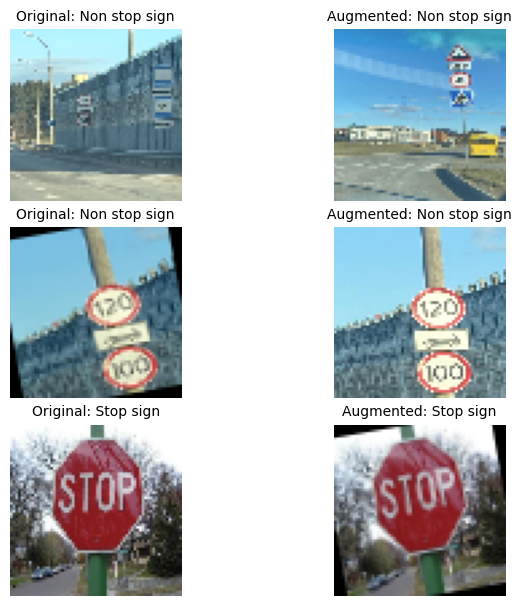

In [ ]:
# Cell: Display Preprocessed Images (Fixed Color)
import matplotlib.pyplot as plt
import numpy as np

# Number of image pairs to display (original + augmented)
num_pairs = 3

# Ensure X is in RGB format. If not, convert it here:
# If your original augmentation step used BGR images, convert before displaying
X_rgb = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img.shape[-1] == 3 else img for img in X])

# Select indices for original images (even indices: 0, 2, 4, ...)
original_indices = np.random.choice(range(0, len(X_rgb), 2), num_pairs, replace=False)

plt.figure(figsize=(8, num_pairs * 2))

for i, orig_idx in enumerate(original_indices):
    orig_img = X_rgb[orig_idx]
    aug_img = X_rgb[orig_idx + 1]
    orig_label = categories[y[orig_idx]]
    aug_label = categories[y[orig_idx + 1]]

    plt.subplot(num_pairs, 2, i * 2 + 1)
    plt.imshow(orig_img)
    plt.title(f"Original: {orig_label}", fontsize=10)
    plt.axis('off')

    plt.subplot(num_pairs, 2, i * 2 + 2)
    plt.imshow(aug_img)
    plt.title(f"Augmented: {aug_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout(pad=0.5)
plt.show()


Split the Dataset into Training, Validation, and Test Sets

In [ ]:
# Cell 3: Data Splitting
from sklearn.model_selection import train_test_split

# Set a random seed for reproducibility
random_seed = 42

# Assign data and labels to X and y
X = data
y = labels

# Split into training (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=random_seed, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=random_seed, stratify=y_temp
)

# Verify all splits
print("\nTraining set:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("\nValidation set:")
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("\nTest set:")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Assertions to ensure data integrity
assert X_train.shape[0] == y_train.shape[0], "Training set mismatch!"
assert X_val.shape[0] == y_val.shape[0], "Validation set mismatch!"
assert X_test.shape[0] == y_test.shape[0], "Test set mismatch!"

print("\nData successfully split into training, validation, and test sets.")



Training set:
X_train shape: (180, 64, 64, 3)
y_train shape: (180,)

Validation set:
X_val shape: (60, 64, 64, 3)
y_val shape: (60,)

Test set:
X_test shape: (60, 64, 64, 3)
y_test shape: (60,)

Data successfully split into training, validation, and test sets.


In [ ]:
# Cell 4: Normalize Images
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print("Normalized image pixel values to range [0, 1].")


Normalized image pixel values to range [0, 1].


CNN model Training

In [ ]:
# Cell 5: Model Training (CNN)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import random

# Set seeds for reproducibility
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

num_classes = len(categories)

# Define the model
model = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.6),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model using raw integer labels (0 or 1), not one-hot
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping, checkpoint],
    verbose=1,
    shuffle=True
)

# Save the model
model.save('cnn_model.keras')

# Print results
print("CNN model trained and saved as 'cnn_model.keras'.")
print("Final training accuracy:", history.history['accuracy'][-1])
print("Final validation accuracy:", history.history['val_accuracy'][-1])


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.5078 - loss: 2.7446 - val_accuracy: 0.5667 - val_loss: 1.6025
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.6587 - loss: 1.3352 - val_accuracy: 0.8833 - val_loss: 0.7758
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8263 - loss: 0.7522 - val_accuracy: 0.8667 - val_loss: 0.5537
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9060 - loss: 0.4920 - val_accuracy: 0.9167 - val_loss: 0.3493
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9260 - loss: 0.3852 - val_accuracy: 0.9167 - val_loss: 0.2911
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9361 - loss: 0.3337 - val_accuracy: 0.9000 - val_loss: 0.3109
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.9392 - loss: 0.3043 - val_accuracy: 0.9500 - val_loss: 0.2323
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.9325 - loss: 0.2696 - val_accu

Test Set

In [ ]:
# Cell 6: Model Testing
import tensorflow as tf
import numpy as np

# Load the trained model
model = tf.keras.models.load_model('cnn_model.keras')

# Evaluate on test set using raw binary labels (0 or 1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Predict on test set
y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype("int32").flatten()  # Convert probabilities to class labels (0 or 1)

# Print results
print("\nTest Set Evaluation:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step

Test Set Evaluation:
Test Loss: 0.0553
Test Accuracy: 0.9833


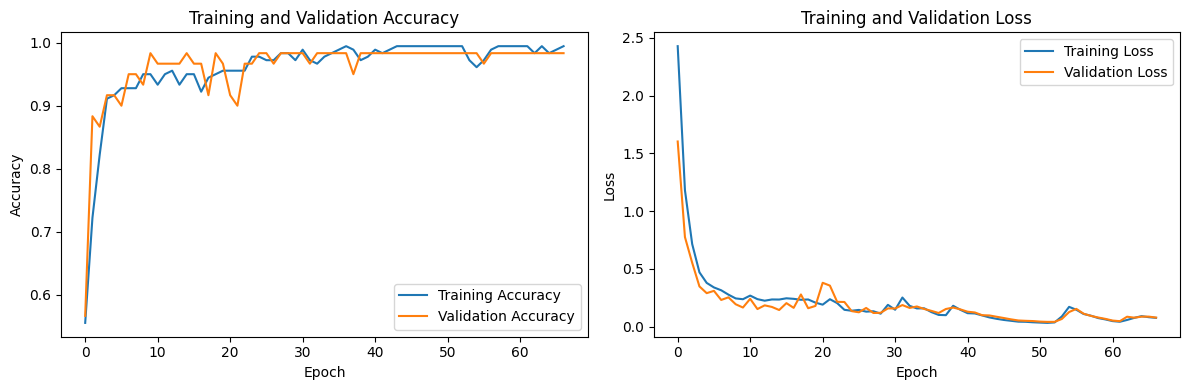

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


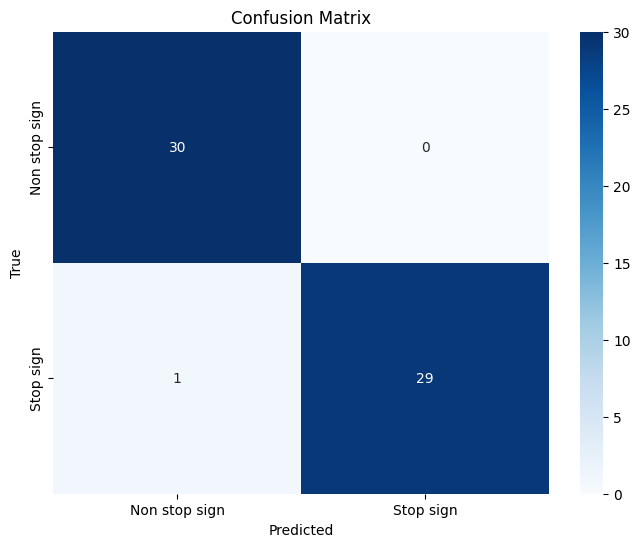


Classification Report:
               precision    recall  f1-score   support

Non stop sign       0.97      1.00      0.98        30
    Stop sign       1.00      0.97      0.98        30

     accuracy                           0.98        60
    macro avg       0.98      0.98      0.98        60
 weighted avg       0.98      0.98      0.98        60



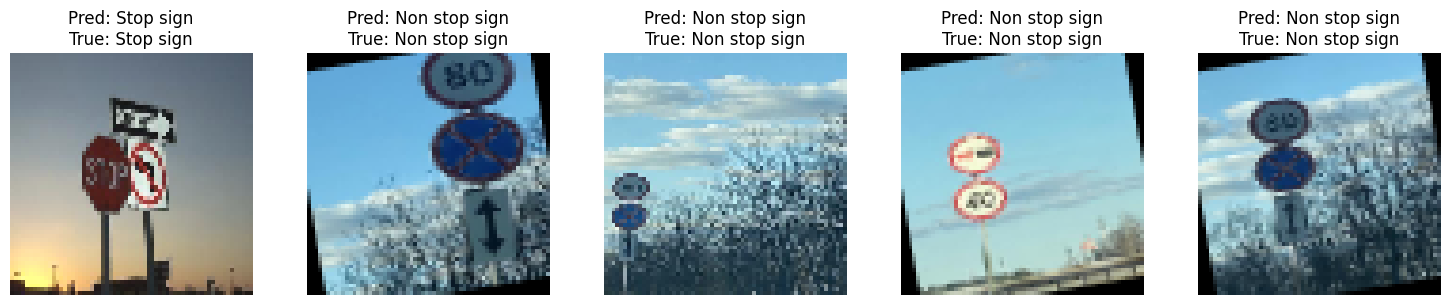

In [ ]:
# Cell 7: Output and Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Predictions
y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype("int32").flatten()
y_test_classes = y_test.flatten()  # ensure correct shape

# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=categories, zero_division=0))

# Display some example predictions
num_examples = 5
indices = np.random.choice(len(X_test), num_examples, replace=False)
plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    plt.subplot(1, num_examples, i + 1)

    img = X_test[idx]
    plt.imshow(img)  # Images already in RGB (after preprocessing)
    pred_label = categories[y_pred_classes[idx]]
    true_label = categories[y_test_classes[idx]]
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()
